In [1]:
from models.classification_model import ClassifierModel # class with classifiers
from models.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import joblib
from copy import deepcopy

# plt.rcParams['text.usetex'] = True

In [2]:
dataset = pd.read_csv("preprocessing/datasets/main_dataset.csv", index_col=0)
target = pd.read_csv("preprocessing/datasets/main_target.csv", index_col=0)

In [3]:
reduce_model = joblib.load("models/best/reduce_model.pkl")
c_model = joblib.load("models/best/c_model.pkl")

In [4]:
main_reduced = reduce_model.transform(dataset)

In [5]:
def clf_per_seed(n=10, metric = ClassifierModel.score):
    clfs = deepcopy(c_model)
    result = {name: [0.]*n for name in clfs.models}
    result["Median"] = [0.]*n
    for seed in range(0, n):
        X_train, X_test, y_train, y_test = train_test_split(
        main_reduced, target.values.ravel(), test_size=0.2, random_state=seed,
        #stratify=target.values.ravel()
        )
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for clf in clfs.models:
            clfs.models[clf].fit(X_train, y_train)
            result[clf][seed] = metric(y_test, clfs.models[clf].predict(X_test))
        result["Median"][seed] = metric(y_test, np.ones_like(y_test)*np.median(y_test))
    
    
    return result
    

In [6]:
r = pd.DataFrame(clf_per_seed(100))
print(r.mean())
print(r.std())

CatBoost    0.601560
RF          0.653183
AdaBoost    0.618713
kNN         0.699237
Median      0.294863
dtype: float64
CatBoost    0.136724
RF          0.117177
AdaBoost    0.130492
kNN         0.120785
Median      0.034460
dtype: float64


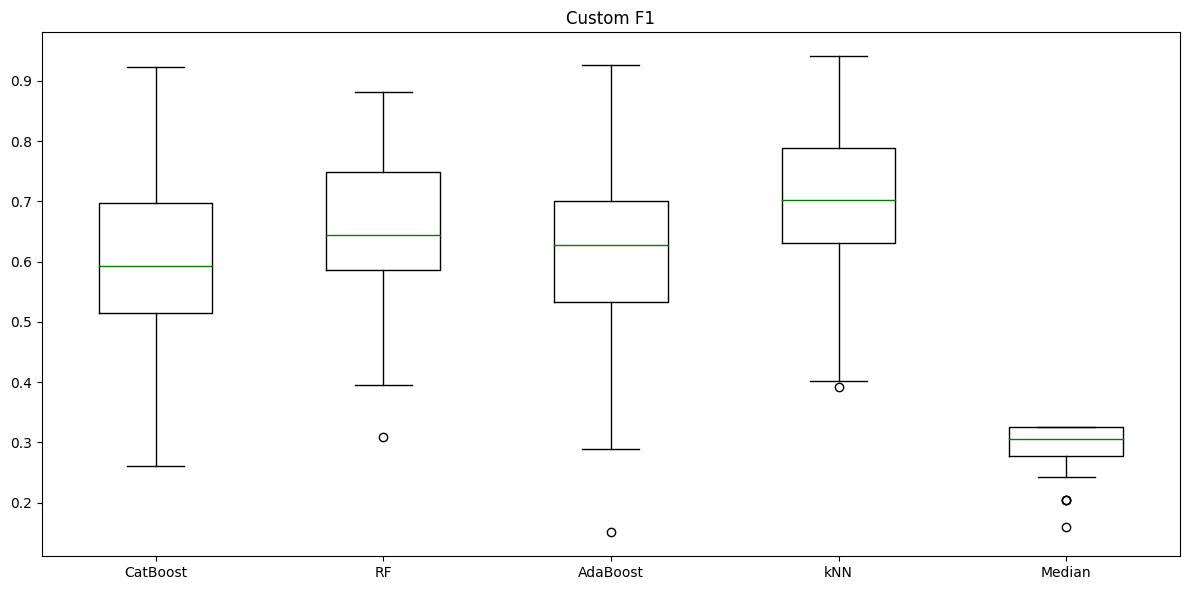

In [7]:
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="k"),
            capprops=dict(color="k"),
            whiskerprops=dict(color="k"),
            medianprops=dict(color="g"),
            flierprops=dict(color="k", markeredgecolor="k"),
            )



plt.title("Custom F1")
plt.tight_layout()
plt.show()

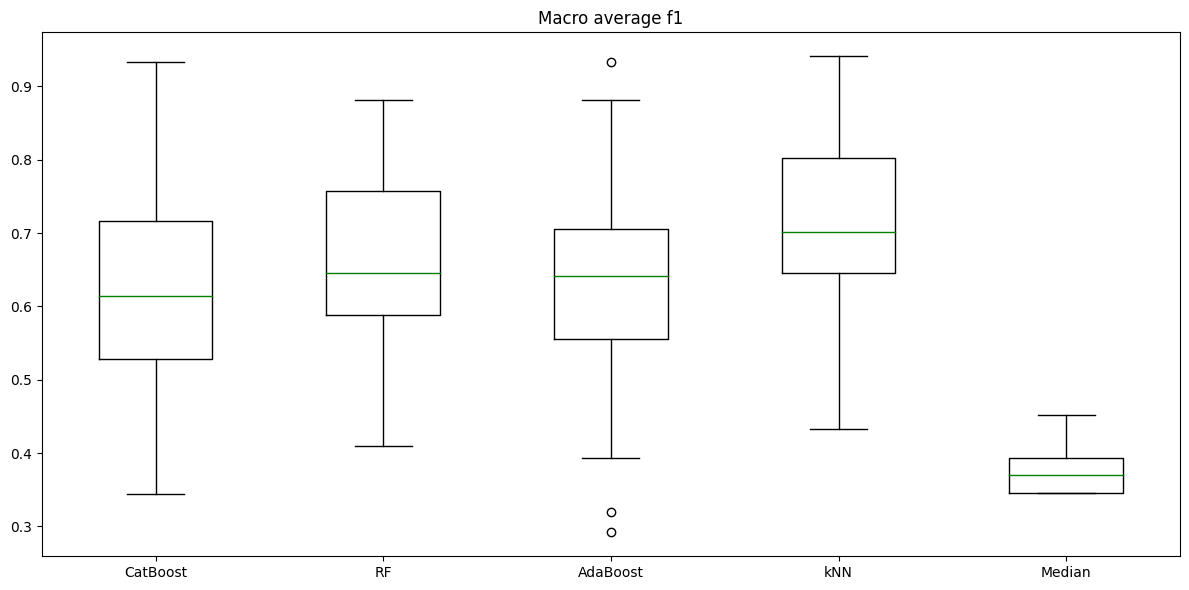

In [8]:
r = pd.DataFrame(clf_per_seed(100, lambda y_t, y_p: metrics.f1_score(y_t, y_p, average="macro")))
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="k"),
            capprops=dict(color="k"),
            whiskerprops=dict(color="k"),
            medianprops=dict(color="g"),
            flierprops=dict(color="k", markeredgecolor="k"),
            )
plt.title("Macro average f1")
plt.tight_layout()
plt.show()

In [9]:
print(r.mean())
print(r.std())

CatBoost    0.620897
RF          0.666536
AdaBoost    0.633583
kNN         0.713016
Median      0.374304
dtype: float64
CatBoost    0.124941
RF          0.108057
AdaBoost    0.120993
kNN         0.110450
Median      0.026631
dtype: float64


In [10]:
def roc_auc_per_seed(n=10):
    clfs = deepcopy(c_model)
    result = {name: [0.]*n for name in clfs.models}
    for seed in range(0, n):
        X_train, X_test, y_train, y_test = train_test_split(
            main_reduced, target.values.ravel(), test_size=0.2, random_state=seed,
            #stratify=target.values.ravel()
            )
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for clf in clfs.models:
            clfs.models[clf].fit(X_train, y_train)
            pred_proba = clfs.models[clf].predict_proba(X_test)
            fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
            auc = metrics.auc(fpr, tpr)
            result[clf][seed] = auc

    return result

CatBoost    0.718375
RF          0.774709
AdaBoost    0.697716
kNN         0.810614
dtype: float64
CatBoost    0.132001
RF          0.102415
AdaBoost    0.126848
kNN         0.111387
dtype: float64


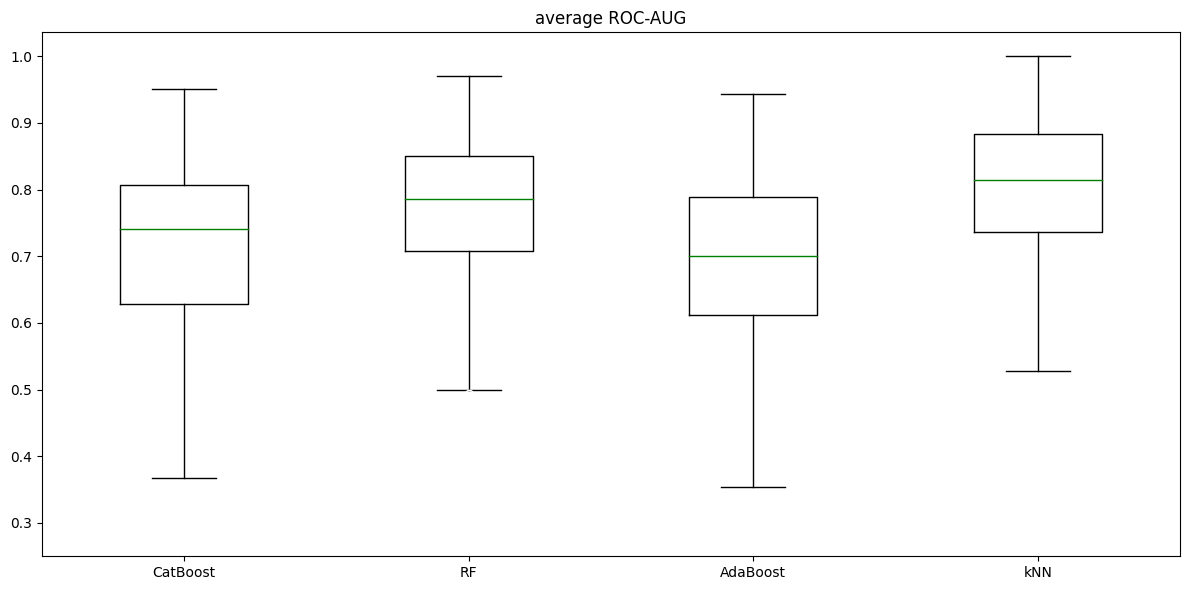

In [11]:
r = pd.DataFrame(roc_auc_per_seed(100))
print(r.mean())
print(r.std())
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="k"),
            capprops=dict(color="k"),
            whiskerprops=dict(color="k"),
            medianprops=dict(color="g"),
            flierprops=dict(color="k", markeredgecolor="w"),
            )
plt.title("average ROC-AUG")
plt.tight_layout()
plt.show()